Sử dụng thiết bị: cuda
Tải dữ liệu thành công.
Epoch 1/100 | Train Loss: 0.3799 | Val Loss: 0.2452
Epoch 2/100 | Train Loss: 0.3267 | Val Loss: 0.2390
Epoch 3/100 | Train Loss: 0.3219 | Val Loss: 0.2446
Epoch 4/100 | Train Loss: 0.3176 | Val Loss: 0.2404
Epoch 5/100 | Train Loss: 0.3170 | Val Loss: 0.2434
Epoch 6/100 | Train Loss: 0.3152 | Val Loss: 0.2393
Epoch 7/100 | Train Loss: 0.3146 | Val Loss: 0.2363
Epoch 8/100 | Train Loss: 0.3142 | Val Loss: 0.2385
Epoch 9/100 | Train Loss: 0.3127 | Val Loss: 0.2377
Epoch 10/100 | Train Loss: 0.3129 | Val Loss: 0.2440
Epoch 11/100 | Train Loss: 0.3118 | Val Loss: 0.2373
Epoch 12/100 | Train Loss: 0.3120 | Val Loss: 0.2396
Epoch 13/100 | Train Loss: 0.3112 | Val Loss: 0.2380
Epoch 14/100 | Train Loss: 0.3114 | Val Loss: 0.2432
Epoch 15/100 | Train Loss: 0.3118 | Val Loss: 0.2465
Epoch 16/100 | Train Loss: 0.3107 | Val Loss: 0.2364
Epoch 17/100 | Train Loss: 0.3112 | Val Loss: 0.2450
Epoch 18/100 | Train Loss: 0.3107 | Val Loss: 0.2360
Epoch 19

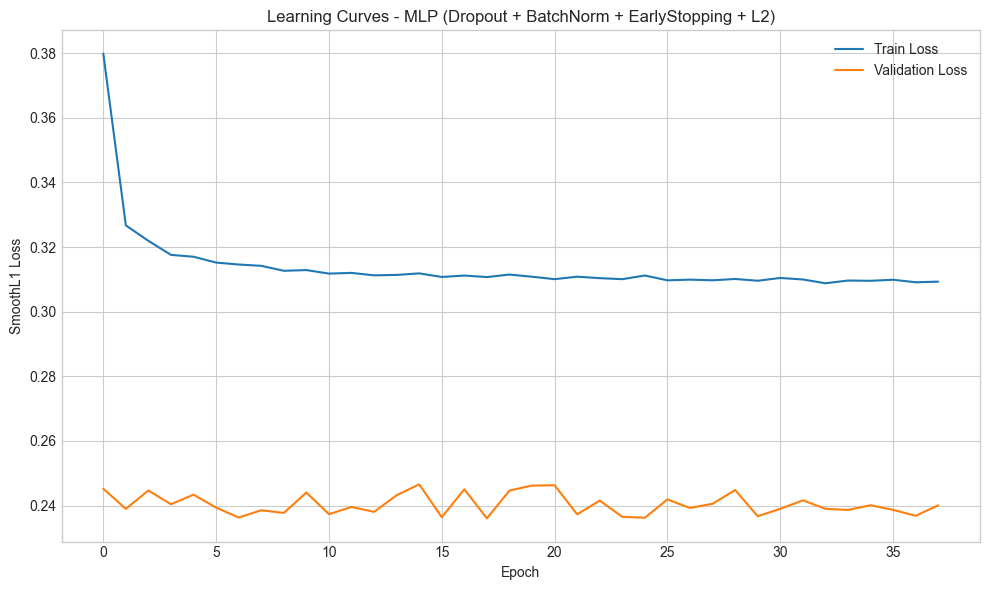


Kết quả mô hình:
 - MAE: 0.5648
 - RMSE: 0.7071
 - R² Score: 0.8234


In [1]:
# === PHẦN 0: IMPORT & THIẾT BỊ ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# === PHẦN 1: LOAD DATA ===
data_loaded_successfully = False
try:
    df = pd.read_csv('clean_student_data_v1.csv')
    print("Tải dữ liệu thành công.")
    TARGET_COLUMN = 'raw_score'
    DROP_COLUMNS = ['year','raw_score', 'student_id','cumulative_gpa', 'current_semester_gpa','previous_courses_taken',
                    'previous_credits_earned','expected_difficulty','subject_type','expected_score_hint', 'fail_rate_general', 'fail_rate_major']
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train_raw.select_dtypes(include=np.number).columns
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)
    data_loaded_successfully = True
except FileNotFoundError:
    print("Không tìm thấy file.")

# === PHẦN 2: MLPRegressor (BatchNorm + Dropout + L2 + SmoothL1 + Save) ===
# === PHẦN 2: MLP sâu + Weighted Loss ===
if data_loaded_successfully:
    # Chuẩn bị dữ liệu
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # === TẠO TRỌNG SỐ MẪU: mẫu nào y < 5 thì weight = 2, còn lại = 1
    sample_weights = np.where(y_train.values < 5, 2.0, 1.0)
    sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor, sample_weights_tensor),
                              batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                             batch_size=64, shuffle=False)

    input_dim = X_train.shape[1]

    class MLPDeep(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.BatchNorm1d(512),
                nn.SiLU(),
                nn.Dropout(0.3),

                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(0.3),

                nn.Linear(256, 128),
                nn.SiLU(),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                nn.SiLU(),

                nn.Linear(64, 32),
                nn.SiLU(),

                nn.Linear(32, 1)
            )

        def forward(self, x):
            return self.model(x)

    model = MLPDeep(input_dim).to(device)
    loss_fn = nn.SmoothL1Loss(reduction='none')  # Phải dùng reduction='none' để nhân với trọng số
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 20  # tăng patience cho mạng sâu
    patience_counter = 0
    train_losses, val_losses = [], []

    epochs = 100
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb, wb in train_loader:
            xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            weighted_loss = (loss * wb).mean()

            optimizer.zero_grad()
            weighted_loss.backward()
            optimizer.step()
            total_train_loss += weighted_loss.item() * xb.size(0)

        # Validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb).mean()
                total_val_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_val_loss = total_val_loss / len(test_loader.dataset)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, "best_mlp_model_weighted_2_8_2025.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping tại epoch {epoch+1}")
                break

    # Load lại mô hình tốt nhất
    model.load_state_dict(torch.load("best_mlp_model_weighted_2_8_2025.pt"))

    # Learning curves
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('SmoothL1 Loss')
    plt.title('Learning Curves - MLP (Dropout + BatchNorm + EarlyStopping + L2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor.to(device)).squeeze().cpu().numpy()
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    print(f"\nKết quả mô hình:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}\n - R² Score: {r2:.4f}")
    # === PHẦN 3: PERMUTATION FEATURE IMPORTANCE ===

def permutation_importance(model, X_tensor, y_tensor, metric=mean_squared_error, n_repeats=5):
    model.eval()
    base_pred = model(X_tensor.to(device)).detach().cpu().numpy()
    base_score = metric(y_tensor.numpy(), base_pred)

    importances = np.zeros(X_tensor.shape[1])

    for col in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            idx = torch.randperm(X_tensor.shape[0])
            X_permuted[:, col] = X_permuted[idx, col]
            pred = model(X_permuted.to(device)).detach().cpu().numpy()
            score = metric(y_tensor.numpy(), pred)
            scores.append(score - base_score)
        importances[col] = np.mean(scores)
    
    return importances

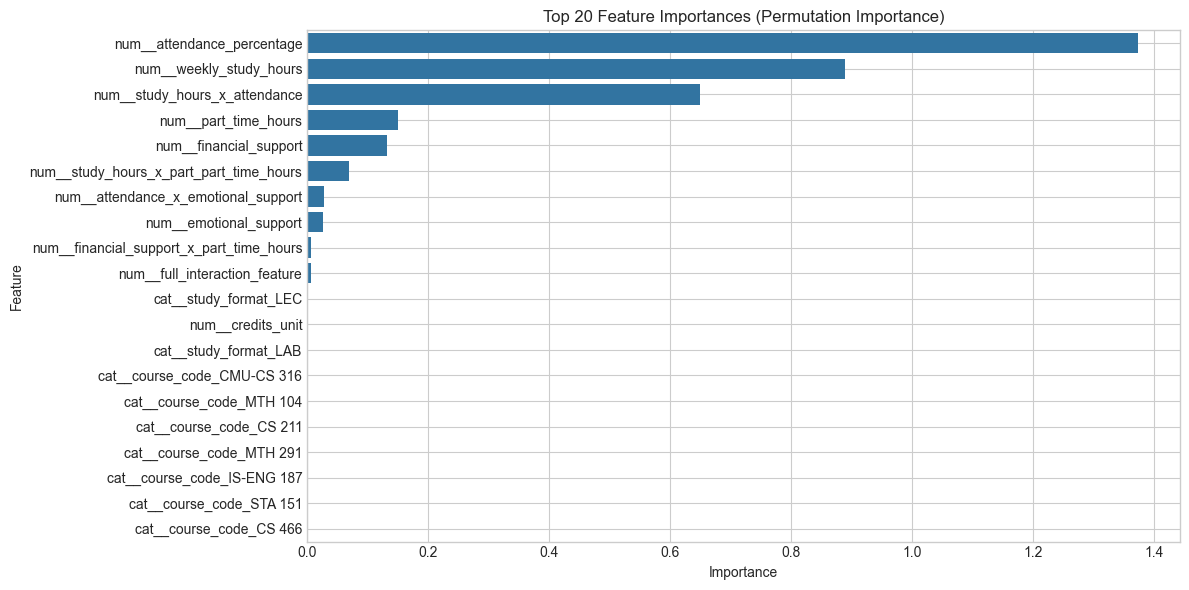

In [3]:
# Tính độ quan trọng
importances = permutation_importance(model, X_test_tensor, y_test_tensor, metric=mean_squared_error, n_repeats=5)
# Lấy tên đặc trưng đã được transform
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Hiển thị top 20 đặc trưng quan trọng nhất
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Feature Importances (Permutation Importance)")
plt.tight_layout()
plt.grid(True)
plt.show()

In [3]:
input_dim = X_train.shape[1]
model = MLPDeep(input_dim)
model.load_state_dict(torch.load("best_mlp_model_weighted_2_8_2025.pt"))
model.to(device)
model.eval()


MLPDeep(
  (model): Sequential(
    (0): Linear(in_features=75, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SiLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): SiLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): SiLU()
    (13): Linear(in_features=64, out_features=32, bias=True)
    (14): SiLU()
    (15): Linear(in_features=32, out_features=1, bias=True)
  )
)

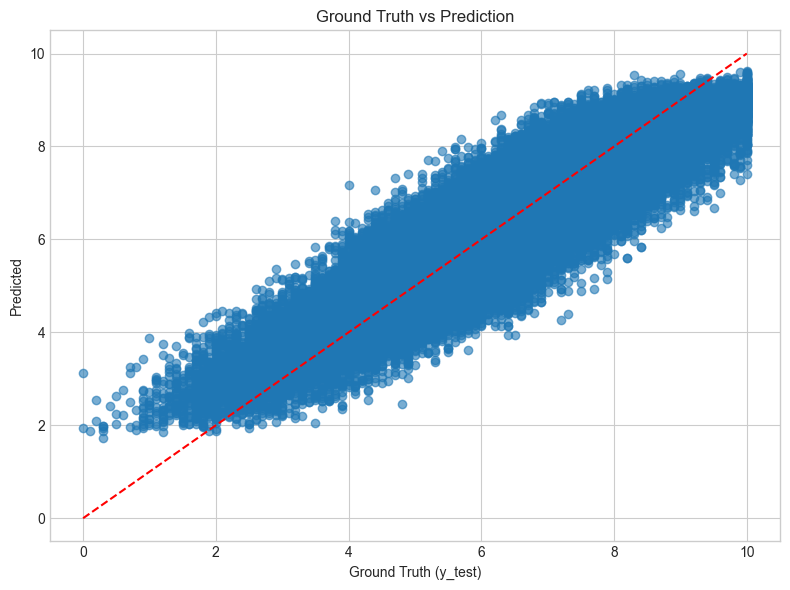

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Ground Truth (y_test)')
plt.ylabel('Predicted')
plt.title('Ground Truth vs Prediction')
plt.grid(True)
plt.tight_layout()
plt.show()


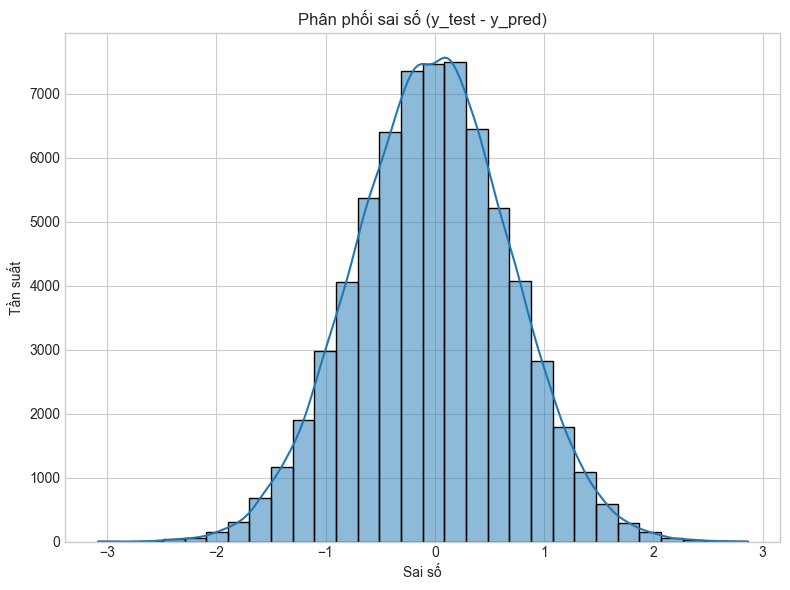

In [5]:
errors = y_test - y_pred_test
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=30, kde=True)
plt.title("Phân phối sai số (y_test - y_pred)")
plt.xlabel("Sai số")
plt.ylabel("Tần suất")
plt.grid(True)
plt.tight_layout()
plt.show()


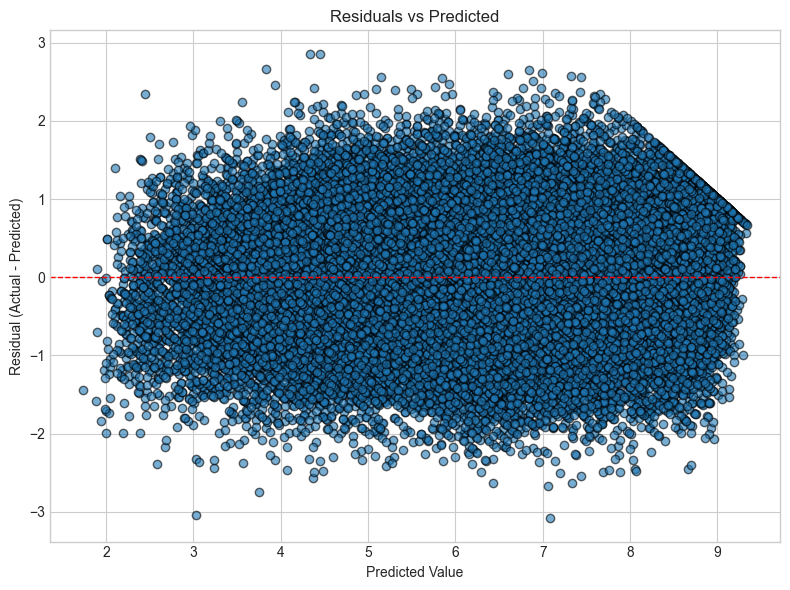

In [7]:
residuals = y_test.values - y_pred_test

# Vẽ biểu đồ Residuals vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()